In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
#이미지 픽셀 크기 확인
print(train_x.max())
print(train_x.min())

255
0


In [4]:
#-1 ~ 1로 정규화
train_x = (train_x - 127.5) / 127.5
#-1에서 1의 값을 가지는지 확인
print(train_x.max())
print(train_x.min())

1.0
-1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

만들어야하는 이미지(32,32,3)과 일치

In [6]:
#데이터 타입을 float32로 지정
train_x = train_x.astype('float32')
print(train_x.shape)

(50000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

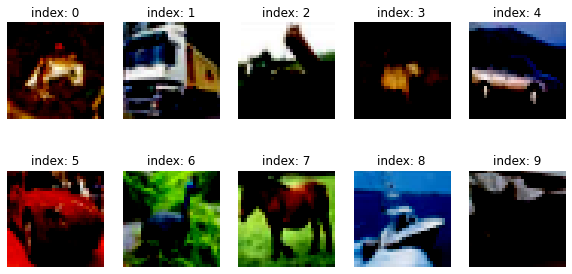

In [7]:
#데이터 시각화 - for 반복문을 통해사용 - 2행 5열 총 10개 이미지 출력
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

대부분 어느정도 알아볼 수 있으나, 뭔지 전혀모르겠는 이미지가 일부 존재

In [8]:
#BUFFER_SIZE를 너무 적게 줄 경우 CPU과부하 가능성. 데이터셋과 동일하게 혹은 많게 주는 것을 추천
#BATCH_SIZE는 한 번에 학습할 데이터양. 너무 큰 숫자를 입력하면 제대로 학습하지 못할 가능성 존재
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
#미니배치학습 구성
#slices는 리스트를 하나씩 나눌때 사용
#shuffle은 랜덤하게 섞을 때 사용 - 이 경우에는 BUFFER_SIZE를 섞는 것
#.batch는 자료를 batch_size만큼 묶음 >>> 이 경우에는 앞 256개를 묶은 다음 다음 256개를 묶고... 계속 반복
#나머지가 256보다 적은경우 256보다 적은대로 묶어주고 종료
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델 구현

In [10]:
def make_generator_model():

    # 시작
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

다행히 32,32,3의 3차원이 무사히 나왔다

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
#학습하는 단계가 아니기 때문에 training은 False로 설정
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

* 모델과 동일한 32,32,3이 나왔으므로 계속 진행
* 1,32,32,3에서 1은 배치사이즈=1의 뜻을 가짐

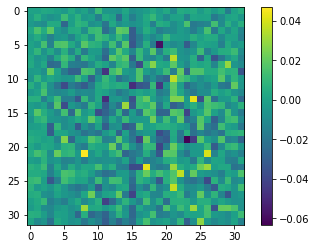

In [14]:
#matplotlib는 2차원 이미지만 보여줄 수 있음
#0,3번째 인덱스를 0으로 설정해서 32,32 이미지를 꺼내게 하여야 함
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# 판별자 모델 구현

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [17]:
#생성자 함수에 노이즈를 넣은 값 출력
#지금 당장은 텐서형태로만 존재
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00340942]], dtype=float32)>

# 손실함수, 최적화함수 구현

In [18]:
#binarycrossentropy에 아무런 값을 설정해두지않으면 인풋값이 0~1로 나올 것이라 예측함
#from_logits를 True로 설정하여 logits값을 텐서로 인식할지의 여부
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 생성자 손실

In [19]:
#generator_loss는 fake_output이 1에 가까워지는 것을 목표로 함.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 판별자 손실

In [20]:
#discriminator_loss는 real_output값은1, fake_output의 값은 0에 가까워지는 것이 목표
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 판별자 정확도

In [21]:
#tf.math.greater_equal은 real_output의 값이 0.5이상인지 True, False로 판별
#tf.cast( ~, tf.float32) 에서 ~의 결과가 True면 1, False면 0을 반환
#tf.reduce_mean((ㅡ))  ㅡ의 결과를 평균내어 정확도 계산

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### optimizer = 최적화함수 설정

In [22]:
#1e-4 = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

#tf.random.normal은 정규분포난수를 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    #(3) tf.GradientTape() 는 중간 연산과정을 기록 - gradient를 자동미분하기위함
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [25]:
#훈련 과정 동안 생성한 이미지를 시각화
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [26]:
#epoch마다 loss, accuracy, history 그래프로 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [27]:
# 수 에포치마다 모델을 저장하는 모듈 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 학습 진행

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

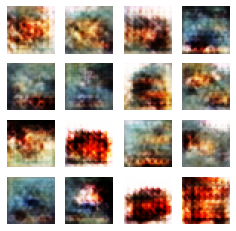

Time for training : 1459 sec


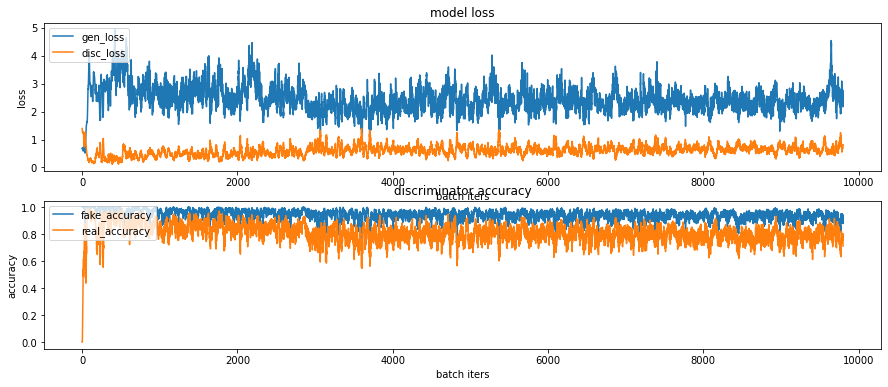

CPU times: user 26min 7s, sys: 1min 48s, total: 27min 56s
Wall time: 24min 20s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성
# 진행 과정을 수시로 확인

실제 이미지 정확도가 0.8인것을 봤을 때 아직은 생성자가 이미지를 잘 만들어내지 못한다.

# 추가학습

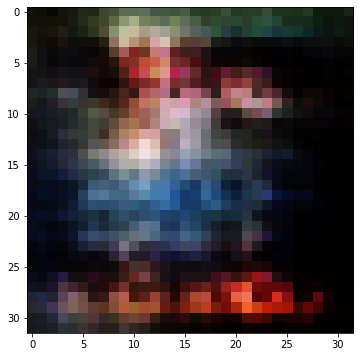

In [31]:
#체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 CIFAR-10 이미지가 그려질 것

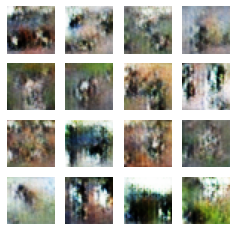

Time for training : 2906 sec


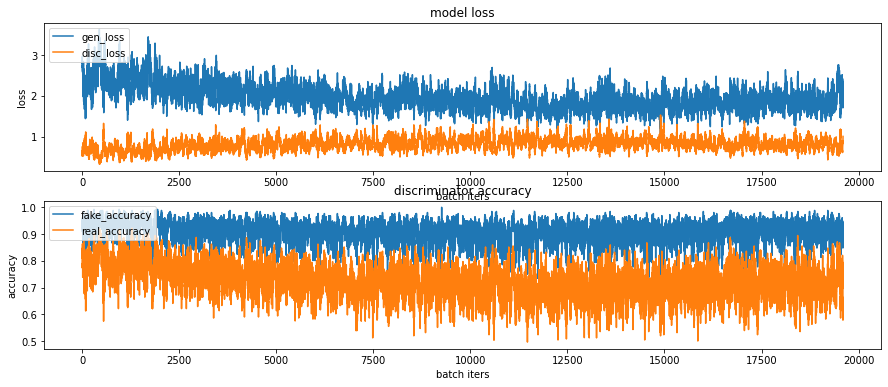

CPU times: user 52min 33s, sys: 3min 34s, total: 56min 7s
Wall time: 48min 27s


In [32]:
%%time
save_every = 5
EPOCHS = 100
train(train_dataset, EPOCHS, save_every)

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1564065 Feb  8 10:32 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


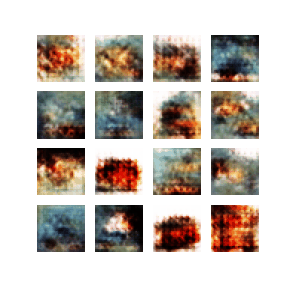

In [35]:
display.Image(filename="./aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif")

기존 50번에서 100번을 더 추가한 150번을 추가로 훈련시켰다.
epoch가 많아질수록 내려가는 폭이 커지는 것을 볼 수 있다.
그럼에도 real_accuracy의 최솟값이 0.6을 맴도는 것을 봤을 때 추가로 하이퍼 파라미터를 건드릴 필요가 있어보인다.

BUFFER_SIZE = 70000, BATCH_SIZE = 128, generator_optimizer & discriminator_optimizer를 adam은 그대로두고(1e-6)으로 수정, dropout 0.2로 수정

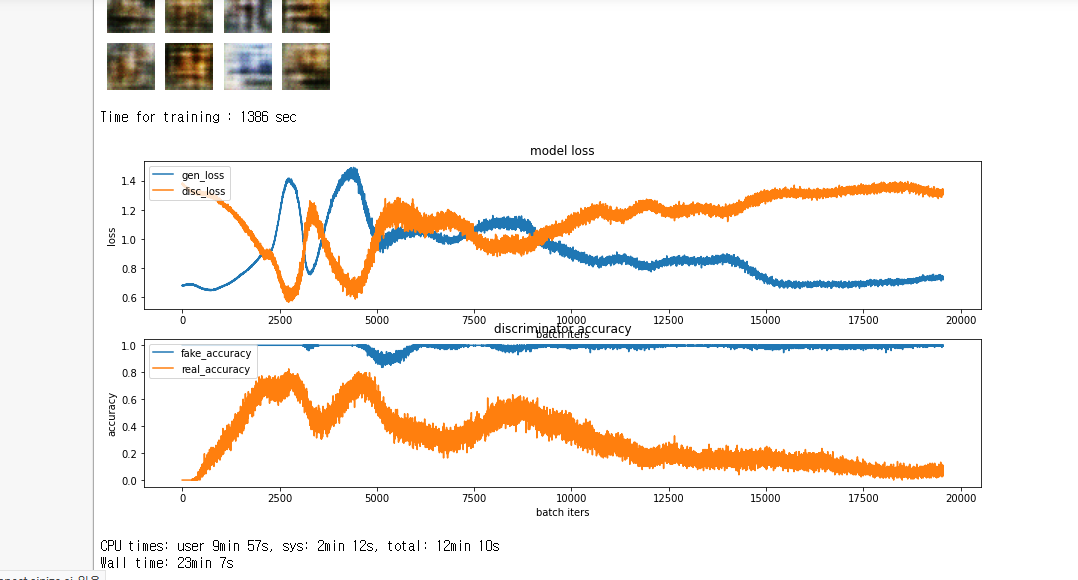

In [36]:
display.Image(filename="./aiffel/dcgan_newimage/111.png")

로스값이 갈수록 하늘을 뚫고, 정확도가 바닥을 기는 상황이다.
가장 문제인점은 러닝레이트를 너무 낮게잡았다.
버퍼사이즈는 보통 크거나 같게 주는 것이 보통이라해서 일부러 크게줬었다. 버퍼사이즈가 어떤 영향을 끼치는지 확인할 수 없으므로 러닝레이트를 1e-3으로 두고 다시 시도해보려고 한다. 또한 드롭아웃 수치의 디폴트값이 0.2여서 딱 0.2만 줬는데, 이것보다 더 많이줘서 0.5인 상태로 훈련을 시켜보려고 한다.

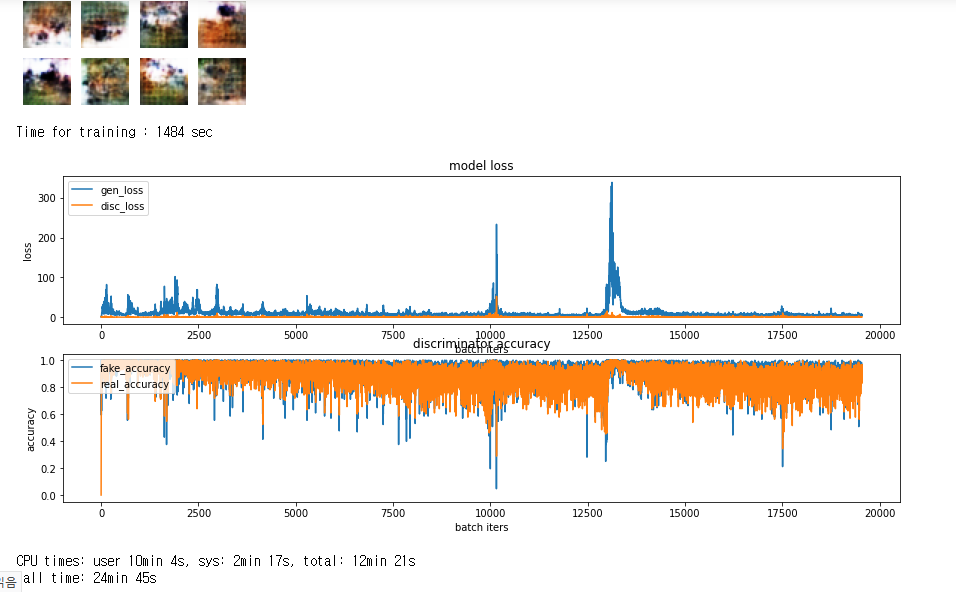

In [37]:
display.Image(filename="./aiffel/dcgan_newimage/222.png")

상상이상으로 매우 잘 나왔다. 기존의 것과 수치차이가 거의 없을 줄 알았는데 각 정확도의 최저치가 0.5에 수렴하게 되었다. 훈련 횟수를 조금 더 늘릴 경우 더 나은 값이 나올 것으로 예상된다. 본문과 마찬가지로 100을 더한 150회를 훈련하고자 한다.

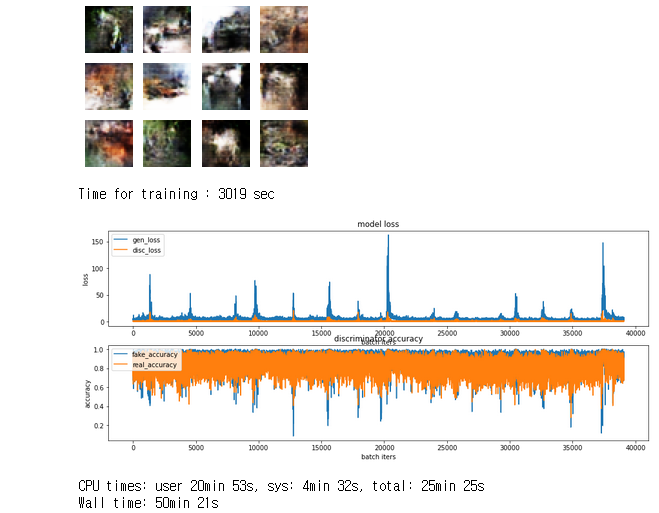

In [38]:
display.Image(filename="./aiffel/dcgan_newimage/333.png")

이전보다 조금 더 0.5에 가까운 수렴값을 가지게 되었다. 하지만, 로스값이 중간중간 튀는 부분이 너무 많아졌다. 뿐만 아니라 fake, real 값의 정확도는 최댓값이 1.0에 수렴할 정도로 높다. 처음에는 최솟값만 도달하면 될 것이라고 생각했으나, 학습을 여러번 시켜보면서 최댓값이 적어도 0.8까지는 떨어져야할 것 같다는 느낌이 들었다.

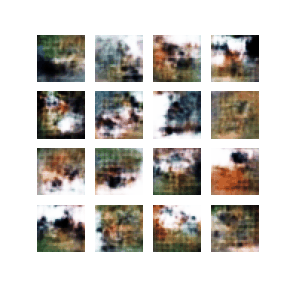

In [39]:
display.Image(filename="./aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif")

이미지의 해상도는 이전보다 낫지만 아직 손봐야 할 곳이 많습니다.
이미지를 봤을 때 변하는 부분이 너무 적은데, 러닝레이트를 조금 더 늘리면 더 나은 결과가 나올 것으로 예상됩니다.
그리고 드롭아웃의 비율을 조금 더 줄여야 할 것 같습니다. 첫 훈련 결과때 0.3을 줬을때 불만족스러운 부분이 있어서 0.5까지 올렸더니 전달되어야 하는 정보가 전달되지 못한 것 같습니다.
이런 부분을 고려해서 앞으로는 과도한 드랍아웃을 주는 것은 자제하여야 할 듯 싶습니다.

# 회고

checkpoint를 사용하였음에도 학습하는 시간이 상당히 길었습니다.
그리드서치와 같이 값을 입력하면 최적의 예측값을 출력하는 것이 있다면 좋겠다는 생각이 들었습니다.
하이퍼파라미터를 설정하는 방법 외에도 훈련 진입시 색 변형등 신경쓰지 못한 부분이 많아서 그 부분에 대한 보완이 더 필요합니다.
코드에 대해 익숙해지는 것도 중요하지만, 이론을 통해 배우는 것도 필요하다는 것을 배울 수 있었습니다.